In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, t
from numpy.linalg import cholesky, eig
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import spearmanr

Q1

In [2]:
import pandas as pd
import numpy as np

file_path = "DailyPrices.csv"
df = pd.read_csv(file_path)

selected_stocks = ["SPY", "AAPL", "EQIX"]
df_selected = df[["Date"] + selected_stocks]

arithmetic_returns = df_selected.drop(columns=["Date"]).pct_change()
arithmetic_mean = arithmetic_returns.mean()
arithmetic_returns -= arithmetic_mean
arithmetic_stock_std = arithmetic_returns.std()
arithmetic_total_std = arithmetic_stock_std.sum()


arithmetic_returns.insert(0, "Date", df_selected["Date"])
arithmetic_returns = arithmetic_returns.dropna()


log_returns = np.log(df_selected.drop(columns=["Date"]) / df_selected.drop(columns=["Date"]).shift(1))
log_mean = log_returns.mean()
log_returns -= log_mean
log_stock_std = log_returns.std()
log_total_std = log_stock_std.sum()


log_returns.insert(0, "Date", df_selected["Date"])
log_returns = log_returns.dropna()

print("Arithmetic Returns (Last 5 Rows):")
print(arithmetic_returns.tail())
print("\nLog Returns (Last 5 Rows):")
print(log_returns.tail())
print("\nStandard Deviation Per Stock:")
print("Arithmetic Returns:")
print(arithmetic_stock_std)
print("\nLog Returns:")
print(log_stock_std)
print("\nTotal Standard Deviation:")
print(f"Arithmetic Returns: {arithmetic_total_std}")
print(f"Log Returns: {log_total_std}")


Arithmetic Returns (Last 5 Rows):
           Date       SPY      AAPL      EQIX
499  2024-12-27 -0.011492 -0.014678 -0.006966
500  2024-12-30 -0.012377 -0.014699 -0.008064
501  2024-12-31 -0.004603 -0.008493  0.006512
502  2025-01-02 -0.003422 -0.027671  0.000497
503  2025-01-03  0.011538 -0.003445  0.015745

Log Returns (Last 5 Rows):
           Date       SPY      AAPL      EQIX
499  2024-12-27 -0.011515 -0.014675 -0.006867
500  2024-12-30 -0.012410 -0.014696 -0.007972
501  2024-12-31 -0.004577 -0.008427  0.006602
502  2025-01-02 -0.003392 -0.027930  0.000613
503  2025-01-03  0.011494 -0.003356  0.015725

Standard Deviation Per Stock:
Arithmetic Returns:
SPY     0.008077
AAPL    0.013483
EQIX    0.015361
dtype: float64

Log Returns:
SPY     0.008078
AAPL    0.013446
EQIX    0.015270
dtype: float64

Total Standard Deviation:
Arithmetic Returns: 0.03692020042548767
Log Returns: 0.036794890604909536


/Users/zhaojiaxin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Q2

In [3]:
def calculate_ewcov(returns_df, lambda_param=0.97):

    if 'Date' in returns_df.columns:
        returns_df = returns_df.set_index('Date')
    T = len(returns_df)
    N = len(returns_df.columns)
    weights = np.array([lambda_param ** i for i in range(T-1, -1, -1)])
    weights = weights / np.sum(weights)
    weighted_means = np.sum(returns_df.values * weights.reshape(-1, 1), axis=0)
    demeaned_returns = returns_df.values - weighted_means
    cov_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            cov = np.sum(weights * demeaned_returns[:, i] * demeaned_returns[:, j])
            cov_matrix[i, j] = cov
            cov_matrix[j, i] = cov

    return pd.DataFrame(cov_matrix, index=returns_df.columns, columns=returns_df.columns)


def fit_t_dist_zero_mean(x):

    x = np.asarray(x)

    def neg_log_lik(params):
        df_, scale_ = params
        if df_ <= 2.01 or scale_ <= 1e-9:
            return 1e20
        pdf_vals = t.pdf(x, df_, loc=0.0, scale=scale_)
        if np.any(pdf_vals <= 0):
            return 1e20
        return -np.sum(np.log(pdf_vals))
    df_init = 5.0
    scale_init = np.sqrt(np.mean(x**2)) 
    bnds = ((2.01, 100.0), (1e-9, None))
    res = minimize(neg_log_lik, x0=[df_init, scale_init], method="L-BFGS-B", bounds=bnds)
    df_hat, scale_hat = res.x
    return df_hat, scale_hat



1 

In [4]:
df_prices = pd.read_csv("DailyPrices.csv", parse_dates=["Date"])
df_prices.sort_values("Date", inplace=True)

holdings = {
    "SPY":  100.0,
    "AAPL": 200.0,
    "EQIX": 150.0
}

today_str = "2025-01-03"
row_today = df_prices.loc[df_prices["Date"] == today_str]
if row_today.empty:
    raise ValueError(f"Date {today_str} not found in CSV.")

prices_today = {}
for ticker in holdings.keys():
    prices_today[ticker] = float(row_today[ticker].values[0])

portfolio_value = 0.0
for ticker, shares in holdings.items():
    portfolio_value += shares * prices_today[ticker]
print("A) Current Portfolio Value on 2025-01-03 = $", f"{portfolio_value:,.2f}")

A) Current Portfolio Value on 2025-01-03 = $ 251,862.50


2 a

In [5]:
tickers_used = list(holdings.keys())
use_cols = ["Date"] + tickers_used
df_sub = df_prices[use_cols].copy()
df_sub.sort_values("Date", inplace=True)
df_sub.dropna(inplace=True)
df_sub.set_index("Date", inplace=True)
df_ret = df_sub / df_sub.shift(1) - 1.0
df_ret.dropna(inplace=True)
df_ret_zm = df_ret - df_ret.mean(axis=0)

alpha = 0.05
ew_cov_df = calculate_ewcov(df_ret_zm, lambda_param=0.97)
ew_cov = ew_cov_df.values 

z05 = norm.ppf(alpha)
pdf_z05 = norm.pdf(z05)  

asset_vals = np.array([holdings[t] * prices_today[t] for t in tickers_used])
w_dollar = asset_vals / portfolio_value
port_var = w_dollar @ ew_cov @ w_dollar
port_std = np.sqrt(port_var)

var_normal = -z05 * port_std * portfolio_value
es_normal = port_std * (pdf_z05 / alpha) * portfolio_value

print(var_normal)
print(es_normal)

3856.3183014814767
4835.978727805546


2 b

In [6]:
import numpy as np
import pandas as pd
import scipy.stats as st

def method_2b_t_copula(csv_file, selected_stocks, shares_dict, alpha=0.05):
    df_prices = pd.read_csv(csv_file, parse_dates=["Date"])
    df_prices.sort_values("Date", inplace=True, ignore_index=True)
    df_ret = df_prices.copy()
    for stk in selected_stocks:
        df_ret[stk] = df_ret[stk].pct_change()
    df_ret.dropna(inplace=True)

    arithmetic_return_remove_mean = {}
    for stk in selected_stocks:
        arr = df_ret[stk].values
        arr_no_mean = arr - np.mean(arr)
        arithmetic_return_remove_mean[stk] = arr_no_mean
    
    t_params = {}
    for stk in selected_stocks:
        data = arithmetic_return_remove_mean[stk]
        df_, loc_, scale_ = st.t.fit(data, method="MLE")
        t_params[stk] = (df_, loc_, scale_)

    U = pd.DataFrame()
    for stk in selected_stocks:
        df_, loc_, scale_ = t_params[stk]
        data = arithmetic_return_remove_mean[stk]
        U[stk] = st.t.cdf(data, df_, loc_, scale_)
    Z = U.apply(lambda x: st.norm.ppf(x))
    
    R_spearman = Z.corr(method='spearman')
    n_samples = 10000
    np.random.seed(42)
    copula_sim = st.multivariate_normal.rvs(
        mean=np.zeros(len(selected_stocks)),
        cov=R_spearman,
        size=n_samples
    )
    
    sim_returns_t = np.zeros_like(copula_sim)
    for i, stk in enumerate(selected_stocks):
        df_, loc_, scale_ = t_params[stk]
        sim_u = st.norm.cdf(copula_sim[:, i])
        sim_returns_t[:, i] = st.t.ppf(sim_u, df_, loc_, scale_)
    
    latest_row = df_prices.iloc[-1]
    sim_pnl_t = np.zeros(n_samples)
    for i, stk in enumerate(selected_stocks):
        n_shares = shares_dict[stk]
        price_now = latest_row[stk]
        sim_pnl_t += n_shares * price_now * sim_returns_t[:, i]
    
    var_5 = np.percentile(sim_pnl_t, alpha * 100)
    tail_mask = (sim_pnl_t <= var_5)
    if np.any(tail_mask):
        es_5 = sim_pnl_t[tail_mask].mean()
    else:
        es_5 = var_5
    
    portfolio_value = 0.0
    for stk in selected_stocks:
        portfolio_value += shares_dict[stk] * latest_row[stk]
    
    return var_5, es_5, sim_pnl_t, portfolio_value


csv_file = "DailyPrices.csv"

selected_stocks = ["SPY", "AAPL", "EQIX"]
shares_dict = {
    "SPY": 100.0,
    "AAPL": 200.0,
    "EQIX": 150.0
}

alpha = 0.05
var_5, es_5, sim_pnl_t, port_val = method_2b_t_copula(
    csv_file, 
    selected_stocks, 
    shares_dict, 
    alpha=alpha
)

print(f"current value of the portfolio: ${port_val:,.2f}")
print(f"{int(alpha*100)}% VaR = ${-var_5:,.2f}")
print(f"{int(alpha*100)}% ES  = ${-es_5:,.2f}")


current value of the portfolio: $251,862.50
5% VaR = $4,464.07
5% ES  = $6,116.37


2 c 

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import norm
pl_hist = (df_ret_zm.values @ np.array([holdings[t] * prices_today[t] for t in tickers_used]))
var_hist = np.percentile(pl_hist, alpha * 100) 
es_hist = pl_hist[pl_hist <= var_hist].mean() if np.any(pl_hist <= var_hist) else var_hist 
print(f"{int(alpha * 100)}% Historical VaR: ${-var_hist:,.2f}")
print(f"{int(alpha * 100)}% Historical ES: ${-es_hist:,.2f}")

5% Historical VaR: $4,575.03
5% Historical ES: $6,059.39


3A, 3B

In [31]:
import math
from math import log, sqrt, exp
from scipy.stats import norm
from scipy.optimize import brentq

def call_price_bs(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    C = S * norm.cdf(d1) - X * exp(-r*T) * norm.cdf(d2)
    return C

def put_price_bs(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    P = X * exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return P

def implied_vol_call_bs(S, X, T, r, market_price):
    def objective(sigma):
        return call_price_bs(S, X, T, r, sigma) - market_price
    vol_lower, vol_upper = 1e-6, 5.0
    return brentq(objective, vol_lower, vol_upper)

def call_delta(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return norm.cdf(d1)

def put_delta(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return norm.cdf(d1) - 1

def call_vega(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return S * norm.pdf(d1) * sqrt(T)

def call_theta(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    term1 = - (S * norm.pdf(d1) * sigma) / (2.0 * sqrt(T))
    term2 = - r * X * exp(-r*T) * norm.cdf(d2)
    return term1 + term2

def put_theta(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    term1 = - (S * norm.pdf(d1) * sigma) / (2.0 * sqrt(T))
    term2 = r * X * exp(-r*T) * norm.cdf(-d2)
    return term1 + term2

S = 31.0      
X = 30.0      
r = 0.10    
T = 0.25     
call_market_price = 3.0 

sigma_iv = implied_vol_call_bs(S, X, T, r, call_market_price)
print(f"Implied Volatility = {sigma_iv*100:.2f}%")

delta_c = call_delta(S, X, T, r, sigma_iv)
delta_p = put_delta(S, X, T, r, sigma_iv)
vega_c  = call_vega(S, X, T, r, sigma_iv)
theta_c = call_theta(S, X, T, r, sigma_iv)
theta_p = put_theta(S, X, T, r, sigma_iv)

print(f"Delta of Call = {delta_c:.4f}")
print(f"Delta of Put  = {delta_p:.4f}")
print(f"Vega  of Call = {vega_c:.4f}")
print(f"Theta of Call = {theta_c:.4f}")
print(f"Theta of Put  = {theta_p:.4f}")

sigma_new = sigma_iv + 0.01
call_price_current = call_price_bs(S, X, T, r, sigma_iv)
call_price_new = call_price_bs(S, X, T, r, sigma_new)
price_change_actual = call_price_new - call_price_current
price_change_approx = vega_c * 0.01

print(f"actual change = {price_change_actual:.4f}")
print(f"Vega Approximation= {price_change_approx:.4f} ")


Implied Volatility = 33.51%
Delta of Call = 0.6659
Delta of Put  = -0.3341
Vega  of Call = 5.6407
Theta of Call = -5.5446
Theta of Put  = -2.6186
actual change = 0.0565
Vega Approximation= 0.0564 


3C

In [9]:
put_price = put_price_bs(S, X, T, r, sigma_iv)
print(f"Put Price (same T, X) = {put_price:.4f}")

lhs = call_market_price + X*exp(-r*T)
rhs = put_price + S
print(f"LHS = Call + PV(X) = {lhs:.4f}")
print(f"RHS = Put + S      = {rhs:.4f}")
diff = lhs - rhs
print(f"Difference (LHS - RHS) = {diff:.8f}") 

Put Price (same T, X) = 1.2593
LHS = Call + PV(X) = 32.2593
RHS = Put + S      = 32.2593
Difference (LHS - RHS) = 0.00000000


3D

In [10]:
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import brentq

trading_days_per_year = 255
holding_days = 20  
alpha = 0.05      
stock_annual_vol = 0.25 

sigma_daily = stock_annual_vol / math.sqrt(trading_days_per_year)
sigma_20d = sigma_daily * math.sqrt(holding_days)

call_market_price = 3.0  
sigma_iv = implied_vol_call_bs(S, X, T, r, call_market_price)

call_0 = call_price_bs(S, X, T, r, sigma_iv)
put_0  = put_price_bs(S, X, T, r, sigma_iv)
portfolio_0 = call_0 + put_0 + S 

print("\n=== Portfolio Initial Info ===")
print(f"Stock Price        = {S:.2f}")
print(f"Call Price         = {call_0:.4f}")
print(f"Put  Price         = {put_0:.4f}")
print(f"Initial Portfolio  = {portfolio_0:.4f}")


=== Portfolio Initial Info ===
Stock Price        = 31.00
Call Price         = 3.0000
Put  Price         = 1.2593
Initial Portfolio  = 35.2593


3D d

In [ ]:
delta_call = call_delta(S, X, T, r, sigma_iv)
delta_put  = put_delta(S, X, T, r, sigma_iv)
delta_stock= 1.0
portfolio_delta = delta_call + delta_put + delta_stock

theta_call = call_theta(S, X, T, r, sigma_iv)
theta_put = put_theta(S, X, T, r, sigma_iv)  
portfolio_theta = theta_call + theta_put  

dt = holding_days / trading_days_per_year
mean_pnl = portfolio_theta * dt 

std_pnl = abs(portfolio_delta) * S * sigma_20d 
z_alpha = norm.ppf(alpha)
var_delta_normal = -(mean_pnl + z_alpha * std_pnl) 

phi_z = norm.pdf(z_alpha)
es_delta_normal = - (std_pnl * phi_z / alpha + mean_pnl)

print("\n=== (d) Delta-Normal Approximation (with Theta) ===")
print(f"Portfolio Delta = {portfolio_delta:.4f}")
print(f"Portfolio Theta = {portfolio_theta:.4f}")
print(f"Mean of 20d PnL = {mean_pnl:.4f}")
print(f"Std of 20d PnL  = {std_pnl:.4f}")
print(f"VaR  (95%)      = {var_delta_normal:.4f}")
print(f"ES   (95%)      = {es_delta_normal:.4f}")


=== (d) Delta-Normal Approximation (with Theta) ===
Portfolio Delta = 1.3319
Portfolio Theta = -8.1632
Mean of 20d PnL = -0.6403
Std of 20d PnL  = 2.8907
VaR  (95%)      = 5.3951
ES   (95%)      = -5.3225


3De

In [23]:
n_sims = 50000
np.random.seed(42)

mu = 0  
rands = np.random.normal(mu, sigma_20d, n_sims)
S_20d = S * np.exp(rands)

T_new = T - (holding_days / trading_days_per_year)
call_20d = [call_price_bs(s_i, X, T_new, r, sigma_iv) for s_i in S_20d]
put_20d  = [put_price_bs(s_i, X, T_new, r, sigma_iv)  for s_i in S_20d]

portfolio_20d = np.array(call_20d) + np.array(put_20d) + S_20d
pnl = portfolio_20d - portfolio_0

pnl_sorted = np.sort(pnl)
idx_var = int(alpha * n_sims)
var_mc = -pnl_sorted[idx_var]
es_mc = -pnl_sorted[:idx_var].mean()

print("\n=== (e) Monte Carlo Simulation ===")
print(f"Number of sims = {n_sims}")
print(f"Mean of PnL    = {pnl.mean():.4f}")
print(f"VaR  (95%)     = {var_mc:.4f}")
print(f"ES   (95%)     = {es_mc:.4f}")


=== (e) Monte Carlo Simulation ===
Number of sims = 50000
Mean of PnL    = -0.2213
VaR  (95%)     = 4.1190
ES   (95%)     = 4.5785


3E

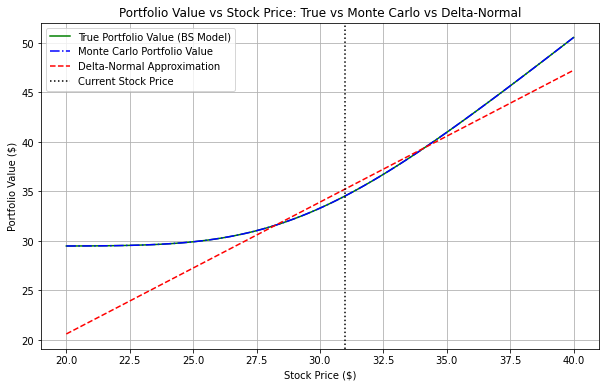

In [27]:
import numpy as np
import matplotlib.pyplot as plt

S_range = np.linspace(20, 40, 100)

call_vals_true = np.array([call_price_bs(s, X, T_new, r, sigma_iv) for s in S_range])
put_vals_true = np.array([put_price_bs(s, X, T_new, r, sigma_iv) for s in S_range])
portfolio_true = call_vals_true + put_vals_true + S_range 


call_vals_mc = np.array([call_price_bs(s, X, T_new, r, sigma_iv) for s in S_range])
put_vals_mc = np.array([put_price_bs(s, X, T_new, r, sigma_iv) for s in S_range])
portfolio_mc = call_vals_mc + put_vals_mc + S_range  

portfolio_dn = portfolio_0 + portfolio_delta * (S_range - S)  

plt.figure(figsize=(10, 6))
plt.plot(S_range, portfolio_true, label="True Portfolio Value (BS Model)", color='green')
plt.plot(S_range, portfolio_mc, label="Monte Carlo Portfolio Value", linestyle="-.", color='blue')
plt.plot(S_range, portfolio_dn, label="Delta-Normal Approximation", linestyle="--", color='red')
plt.axvline(x=S, color='black', linestyle=":", label="Current Stock Price")

plt.xlabel("Stock Price ($)")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value vs Stock Price: True vs Monte Carlo vs Delta-Normal")
plt.legend()
plt.grid(True)
plt.show()
